In [ ]:
!pip install pydicom
# !pip install qpsolvers[open_source_solvers]
import numpy as np
import scipy as sp # good for sparse matrix data storage
import matplotlib.pyplot as plt
import pydicom
import os
import zipfile
import itertools
import time
from tqdm import tqdm # visual progress bar
# from qpsolvers import solve_qp # quadratic programming solver
from numpy.linalg import norm
from scipy.optimize import minimize # minimize object function in TMA part of MSC

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 21.6 MB/s eta 0:00:00


# Mean HU values for Ca and I at various densities (mg/mL)

### Data for spectral CT images

The two images considered are:

* 80 kV, 550 mA (folder 18) slice 40/80
* 135 kV, 200 mA (folder 11) slice 40/80

Image | Ca 50 | Ca 100 | Ca 200 | Ca 300 | Ca 400 | I 2.0 | I 2.5 | I 5.0 | I 7.5 | I 10 | I 15 | I 20 | Bkg Water
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
80 kV, 550 mA | 223 | 416 | 733 | 1096 | 1464 | 52 | 99 | 163 | 289 | 357 | 533 | 712 | -4
135 kV, 200 mA | 180 | 312 | 529 | 734 | 960 | 33 | 47 | 92 | 118 | 180 | 269 | 329 | -19

Standard deviation of HU values for Ca and I at various densities (mg/mL)



Image | Ca 50 | Ca 100 | Ca 200 | Ca 300 | Ca 400 | I 2.0 | I 2.5 | I 5.0 | I 7.5 | I 10 | I 15 | I 20 | Bkg Water
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
80 kV, 550 mA | 156.55 | 189.29 | 246.30 | 267.10 | 282.52 | 205.36 | 239.72 | 202.84 | 209.85 | 242.31 | 258.40 | 287.84 | 181
135 kV, 200 mA | 64.80 | 73.64 | 76.86 | 74.64 | 82.30 | 73.02 | 80.33 | 75.01 | 87.49 | 79.15 | 82.06 | 94.31 | 61

### Data for mono energetic scans

The two mono energy images considered are:

* 70 keV, 200 mA
* 150 keV, 140 mA

Image | Ca 50 | Ca 100 | Ca 200 | Ca 300 | Ca 400 | Ca 500 | Ca 600 | I 2.0 | I 2.5 | I 5.0 | I 7.5 | I 10 | I 15 | I 20 | Bkg Water
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
70 keV, 200 mA | 189 | 329 | 605 | 867 | 1123 | 1385 | 1634 | 40.350 | 54.613 | 117.650 | 180.218 | 242.005 | 352.105 | 476.491 | 0.077
150 keV, 140 mA | 153 | 226 | 375 | 523 | 676 | --- | --- | 9.650 | 12.820 | 24.516 | 38.931 | 54.234 | 81.943 | 106.228 | -0.431

Standard deviation of HU values for Ca and I at various densities (mg/mL)

Image | Ca 50 | Ca 100 | Ca 200 | Ca 300 | Ca 400 | Ca 500 | Ca 600 | I 2.0 | I 2.5 | I 5.0 | I 7.5 | I 10 | I 15 | I 20 | Bkg Water
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
70 keV, 200 mA | 9.385 | 9.726 | 9.387 | 10.747 | 11.241 | 12.690 | 13.270 | 8.855 | 8.687 | 10.046 | 9.628 | 10.467 | 9.876 | 11.418 | 8.235
150 keV, 140 mA | 7.200 | 7.686 | 7.248 | 8.214 | 8.310 | --- | --- |  8.062 | 7.345 | 9.425 | 8.479 | 7.859 | 9.025 | 8.688 | 7.555

### Data dicts from the tables above

In [ ]:
# spectral CT data
Ca80550 = {
    50: (223, 156.55),
    100: (416, 189.29),
    200: (733, 246.30),
    300: (1096, 267.10),
    400: (1464, 282.52)
}
I80550 = {
    2.0: (52, 205.36),
    2.5: (99, 239.72),
    5.0: (163, 202.84),
    7.5: (289, 209.85),
    10: (357, 242.31),
    15: (533, 258.40),
    20: (712, 287.84)
}
BkgWater80550 = [-4, 181]
Ca135200 = {
    50: (180, 64.80),
    100: (312, 73.64),
    200: (529, 76.86),
    300: (734, 74.64),
    400: (960, 82.30)
}
I135200 = {
    2.0: (33, 73.02),
    2.5: (47, 80.33),
    5.0: (92, 75.01),
    7.5: (118, 87.49),
    10: (180, 79.15),
    15: (269, 82.06),
    20: (329, 94.31)
}
BkgWater135200 = [-19, 61]

In [ ]:
# PCCT mono energy data
Ca70200 = {
    50: (189, 9.385),
    100: (329, 9.726),
    200: (605, 9.387),
    300: (867, 10.747),
    400: (1123, 11.241)
}
I70200 = {
    2.0: (40.350, 8.855),
    2.5: (54.613, 8.687),
    5.0: (117.650, 10.046),
    7.5: (180.218, 9.628),
    10: (242.005, 10.467),
    15: (352.105, 9.876),
    20: (476.491, 11.418)
}
BkgWater70200 = [0.077, 8.235]

Ca150140 = {
    50: (153, 7.200),
    100: (226, 7.686),
    200: (375, 7.248),
    300: (523, 8.214),
    400: (676, 8.310)
}
I150140 = {
    2.0: (9.650, 8.062),
    2.5: (12.820, 7.345),
    5.0: (24.516, 9.425),
    7.5: (38.931, 8.479),
    10: (54.234, 7.859),
    15: (81.943, 9.025),
    20: (106.228, 8.688)
}
BkgWater150140 = [-0.431, 7.555]


# Function declarations

In [ ]:
def orthanc_to_numpy(dcms):
    """
    dcms:   list of .dcm image files
    --------------------------------
    returns a list of the image files as numpy arrays
    """
    data_dcms = map(pydicom.dcmread, dcms)

    images = []
    for data in data_dcms:
        pixel_array = data.pixel_array
        rescale_slope = getattr(data, 'RescaleSlope', 1) # default is 1 if slope not found
        rescale_intercept = getattr(data, 'RescaleIntercept', 0) # default is 0 if intercept not found
        image = pixel_array * rescale_slope + rescale_intercept # correct HU in 2D numpy array
        images.append(image)

    return images

In [ ]:
def interpolate_edge(vertex1, vertex2, num_points=100):
    x1, y1 = vertex1
    x2, y2 = vertex2
    all_xs = []
    all_ys = []
    for i in range(num_points + 1):
        t = i / num_points
        x = x1 + t * (x2 - x1)
        y = y1 + t * (y2 - y1)
        all_xs.append(x)
        all_ys.append(y)
    return [all_xs, all_ys]

In [ ]:
def make_triangle(density_Ca, density_I, monoE=True):
    water_coord = [BkgWater70200[0], BkgWater150140[0]]
    Ca_coord = [Ca70200[density_Ca][0], Ca150140[density_Ca][0]]
    I_coord = [I70200[density_I][0], I150140[density_I][0]]
    # each triangle has a cutoff distance = max std dev of the vertices
    d_cutoff = max(BkgWater70200[1], BkgWater150140[1], Ca70200[density_Ca][1], Ca150140[density_Ca][1], I70200[density_I][1], I150140[density_I][1])

    if not monoE:
        water_coord = [BkgWater80550[0], BkgWater135200[0]]
        Ca_coord = [Ca80550[density_Ca][0], Ca135200[density_Ca][0]]
        I_coord = [I80550[density_I][0], I135200[density_I][0]]
        d_cutoff = max(BkgWater80550[1], BkgWater135200[1], Ca80550[density_Ca][1], Ca135200[density_Ca][1], I80550[density_I][1], I135200[density_I][1])

    line1 = interpolate_edge(water_coord, Ca_coord)
    line2 = interpolate_edge(Ca_coord, I_coord)
    line3 = interpolate_edge(water_coord, I_coord)

    return [[line1, line2, line3], [water_coord, Ca_coord, I_coord], d_cutoff]

In [ ]:
def matrix_calculations(triangle_vertices, point):
    """
    triangle_vertices:      [water_coord, Ca_coord, I_coord]
    coord:                  [lowE, highE]
    point:                  [ptx, pty]
    """
    water_coord, Ca_coord, I_coord = triangle_vertices
    ptx, pty = point

    A = np.array([[water_coord[0], Ca_coord[0], I_coord[0]],
     [water_coord[1], Ca_coord[1], I_coord[1]],
      [1, 1, 1]])
    b = np.array([ptx, pty, 1])
    det = np.linalg.det(A)

    if np.abs(det) > 1e-6:
        alpha = np.linalg.inv(A)@b
        alpha[np.abs(alpha) < 1e-4] = 0
        return (A, det, alpha)
    else:
        # matrix A is singular
        # which is very unlikely the case as it would be caused by
        # choosing two of the same materials in the triplet
        return (A, 0, np.zeros(3))

In [ ]:
def hausdorff(T_vertices, point):
    """
    T_vertices:     [vertex1, vertex2, vertex3]
    vertex:         (x, y)
    point:          [ptx, pty]
    """
    def find_closest_vertex(x1,y1, x2,y2, ptx,pty):
        """ helper function """
        dist1 = np.sqrt((x1 - ptx) ** 2 + (y1 - pty) ** 2)
        dist2 = np.sqrt((x2 - ptx) ** 2 + (y2 - pty) ** 2)
        if dist1 < dist2:
            return dist1, [x1,y1]
        else:
            return dist2, [x2,y2]
    tol = 1e-9  # tolerance for floating-point comparisons
    dist = np.inf
    proj_point = None
    ptx, pty = point
    # loop through the three triangle edges to find min distance to the outside point
    # this can result in (a) projection point is on the triangle edge
    # or (b) projection point is on the extension line from the endpoints of the edge
    for i in range(len(T_vertices)):
        for j in range(i+1, len(T_vertices)):
            x1, y1 = T_vertices[i]
            x2, y2 = T_vertices[j]
            # check if the triangle edge is vertical or horizontal
            if np.abs(x1 - x2) < tol: # edge is vertical
                x0 = x1
                y0 = pty
                # check if the projection point [x0, y0] is on the triangle edge
                if min(y1,y2) < y0 < max(y1,y2):
                    dist_from_line = np.abs(x0 - ptx)
                    proj_point_from_line = [x0, y0]
                else:
                    # the projection is outside the edge but on the extension line, so take the closest endpoint
                    dist_from_line, proj_point_from_line = find_closest_vertex(x1,y1, x2,y2, ptx,pty)

            elif np.abs(y1 - y2) < tol: # edge is horizontal
                x0 = ptx
                y0 = y1
                if min(x1,x2) < x0 < max(x1,x2):
                    dist_from_line = np.abs(y0 - pty)
                    proj_point_from_line = [x0, y0]
                else:
                    dist_from_line, proj_point_from_line = find_closest_vertex(x1,y1, x2,y2, ptx,pty)

            else: # edge is neither vertical nor horizontal
                m1 = (y2 - y1) / (x2 - x1)
                m2 = -1 / m1
                # point of projection on the extended line:
                x0 = (m1*x1-y1-m2*ptx+pty)/(m1-m2)
                y0 = m2*(x0-ptx)+pty
                if min(x1, x2) < x0 < max(x1, x2) and min(y1, y2) < y0 < max(y1, y2):
                    dist_from_line = np.sqrt((x0-ptx)**2 + (y0-pty)**2)
                    proj_point_from_line = [x0, y0]
                else:
                    dist_from_line, proj_point_from_line = find_closest_vertex(x1,y1, x2,y2, ptx,pty)

            if dist_from_line < dist:
                dist = dist_from_line
                proj_point = proj_point_from_line
    return [dist, proj_point]

In [ ]:
def mask_image(images, center=[256,256], radius=200):
    """
    images:    list of (512 x 512) 2D numpy arrays
    """
    x, y = np.meshgrid(np.arange(512), np.arange(512))
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    mask = distance < radius
    images_copy = images.copy()
    for idx in range(len(images_copy)):
        images_copy[idx][~mask] = 0
    return images_copy

### Check function declarations

In [ ]:
vertices = [[0,0],[1,0.5],[0.5,1.5]]
line1 = interpolate_edge(vertices[0], vertices[1])
line2 = interpolate_edge(vertices[1], vertices[2])
line3 = interpolate_edge(vertices[0], vertices[2])

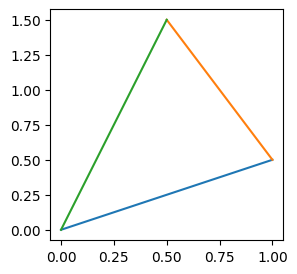

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(line1[0], line1[1])
ax.plot(line2[0], line2[1])
ax.plot(line3[0], line3[1])
fig.show()

In [ ]:
P_outside = [1.5,0.3]
P_outside = [-0.2, 0.1]
vertex1 = [0,0]
vertex2 = [1,1]
vertex3 = [1,0]
T_vertices = [vertex1, vertex2, vertex3]
T_sides = [interpolate_edge(vertex1, vertex2),\
           interpolate_edge(vertex2, vertex3),\
           interpolate_edge(vertex1, vertex3)]
d_hausdorff, proj_point = hausdorff(T_vertices, P_outside)

In [ ]:
d_hausdorff, proj_point

(0.223606797749979, [0, 0])

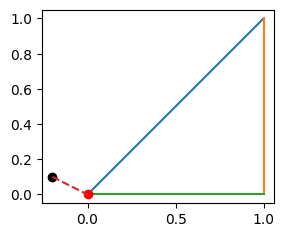

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.plot(T_sides[0][0], T_sides[0][1])
ax.plot(T_sides[1][0], T_sides[1][1])
ax.plot(T_sides[2][0], T_sides[2][1])
ax.plot(P_outside[0], P_outside[1], 'ko')
ax.plot(proj_point[0], proj_point[1], 'ro')
ax.plot([P_outside[0], proj_point[0]], [P_outside[1], proj_point[1]], '--')
fig.gca().set_aspect('equal', adjustable='box')
fig.show()

# The 2014 Algorithm

### Read in dcm files as numpy arrays called `DECT_images`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
path = "/content/drive/My Drive/test_images_dcm"
os.listdir(path)

In [ ]:
# spectral CT data files
lowE_dcm = path+"/"+"80kV_40.dcm"
highE_dcm = path+"/"+"135kV_40.dcm"
DECT_images = orthanc_to_numpy([lowE_dcm, highE_dcm]) # before applying mask
DECT_images[0].shape

In [ ]:
# mono energy PCT data files
lowE_dcm = path+"/"+"monoE_70keV.dcm"
highE_dcm = path+"/"+"monoE_150keV.dcm"
DECT_images = orthanc_to_numpy([lowE_dcm, highE_dcm]) # before applying mask
DECT_images[0].shape

In [ ]:
lowE_image, highE_image = mask_image(DECT_images, [256,256], 200) # images are masked
fig, ax = plt.subplots(1, 2, figsize=(9,3))
im1 = ax[0].imshow(lowE_image, cmap='gray')

fig.colorbar(im1, ax=ax[0])
im2 = ax[1].imshow(highE_image, cmap='gray')
fig.colorbar(im2, ax=ax[1])
fig.show()

In [ ]:
np.max(lowE_image), np.min(lowE_image) # these values are verified with ImageJ

In [ ]:
np.max(highE_image), np.min(highE_image) # these values are verified with ImageJ

### Define all possible triangles in a list called `list_of_triangles` and the relevant concentration maps

In [ ]:
# modify vertices to include more or fewer triangles
vertices = list(itertools.product(Ca70200.keys(), I70200.keys()))
list_of_triangles = [make_triangle(density_Ca=vertex[0], density_I=vertex[1]) for vertex in vertices]
# each triangle has [[edge1, edge2, edge3], [water_coord, Ca_coord, I_coord], d_cutoff]

# create empty residuals for each density
Ca_maps = {vertex[0]: np.zeros(DECT_images[0].shape) for vertex in vertices}
I_maps = {vertex[1]: np.zeros(DECT_images[0].shape) for vertex in vertices}
water_map = np.zeros(DECT_images[0].shape)

In [ ]:
len(vertices) # 5 (Ca densities) * 7 (I densities) = 35 all possible triangles

### Check function declarations with Ca and I densities

In [ ]:
vertices[27], list_of_triangles[27][1] # Ca 300 mg/ml and I 20 mg/ml
# list_of_triangles[27][0] has all points on edges of the triangle

In [ ]:
T1_sides = list_of_triangles[27][0]
T1_vertices = list_of_triangles[27][1] # (Ca300, I20): [[0.077, -0.431], [867, 523], [476.491, 106.228]]
line1 = T1_sides[0]
line2 = T1_sides[1]
line3 = T1_sides[2]
# pt_inside = [380, 220]
# pt_outside = [400, 100]
pt_inside = [400, 180]
pt_outside = [800, 200]
d_hausdorff, proj_point = hausdorff(T1_vertices, pt_outside)

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(line1[0], line1[1])
ax.plot(line2[0], line2[1])
ax.plot(line3[0], line3[1])
ax.plot(pt_inside[0], pt_inside[1], 'ko')
ax.plot(pt_outside[0], pt_outside[1], 'ko')
ax.plot(proj_point[0], proj_point[1], 'ro')
ax.plot([pt_outside[0], proj_point[0]], [pt_outside[1], proj_point[1]], '--')
fig.gca().set_aspect('equal', adjustable='box')
fig.show()

In [ ]:
matrix_calculations(T1_vertices, pt_inside) # all alpha vector elements are positive

In [ ]:
matrix_calculations(T1_vertices, pt_outside) # alpha vector has negative elements

In [ ]:
matrix_calculations(T1_vertices, proj_point)

### Apply the algorithm on a CT scan and get concentration maps

*Takes about 11 mins*

In [ ]:
start_time = time.time()
total_pixels = lowE_image.shape[0] * lowE_image.shape[1]
for px in tqdm(range(total_pixels)): # 512x512, index starts at 0
    row = px // lowE_image.shape[0]
    col = px % lowE_image.shape[1]
    # skip the region outside the phantom
    if lowE_image[row, col] == 0 and highE_image[row, col] == 0:
        continue
    pt = [lowE_image[row, col], highE_image[row, col]] # measured HU point
    dist = np.inf
    soln = [0, 0, 0]

    for idx, triangle in enumerate(list_of_triangles):
        # need idx to access the corresponding vertex density for Ca and I maps
        T_sides, T_vertices, d_cutoff = triangle
        A, det, alpha = matrix_calculations(T_vertices, pt)

        if np.any(alpha < 0):
            d_hausdorff, proj_point = hausdorff(T_vertices, pt)
            if d_hausdorff < dist:
                dist = d_hausdorff
                A, det, alpha = matrix_calculations(T_vertices, proj_point)
                soln = alpha
                vertex_idx = idx
            else:
                continue
        else:
            soln = alpha
            vertex_idx = idx
            break
    # update maps
    if np.all(soln == [0,0,0]):
        # NOTE: this will not happen with the exact 2014 algorithm
        # if we check d_cutoff vs d_hausdorff, then this can happen if measured HU pt is too far away from largest triangle
        water_map[row, col] = 0
        for Ca_density in Ca_maps.keys():
            Ca_maps[Ca_density][row, col] = 0
        for I_density in I_maps.keys():
            I_maps[I_density][row, col] = 0
    else:
        water_map[row, col] = soln[0]
        Ca_density, I_density = vertices[vertex_idx]
        Ca_maps[Ca_density][row, col] = soln[1]
        I_maps[I_density][row, col] = soln[2]
end_time = time.time()
print(f"Elapsed time: {end_time - start_time:.4f} seconds")

### Save the concentration map arrays as csv file and combine in a zip

In [ ]:
with zipfile.ZipFile("concentration_maps.zip", "w") as zipf:
    np.savetxt("water_map.csv", water_map, delimiter=",")
    zipf.write("water_map.csv")
    for Ca_density, Ca_map in Ca_maps.items():
        filename = f"Ca{Ca_density}_map.csv"
        np.savetxt(filename, Ca_map, delimiter=",")
        zipf.write(filename)
    for I_density, I_map in I_maps.items():
        filename = f"I{I_density}_map.csv"
        np.savetxt(filename, I_map, delimiter=",")
        zipf.write(filename)

In [ ]:
# remove .csv files from current directory in Colab
for key in Ca_maps.keys():
    os.remove(f"Ca{key}_map.csv")
for key in I_maps.keys():
    os.remove(f"I{key}_map.csv")
os.remove("watermap.csv")
# os.remove("concentration_maps.zip")

### Plot the individual concentration maps

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
im_Ca = ax[0].imshow(Ca_maps[300], cmap='gray')
im_I = ax[1].imshow(I_maps[20], cmap='gray')
im_water = ax[2].imshow(water_map, cmap='gray')
fig.colorbar(im_Ca, ax=ax[0])
fig.colorbar(im_I, ax=ax[1])
fig.colorbar(im_water, ax=ax[2])
fig.show()

### Plot the final Ca, I, and water images after taking weighted average

$$ \alpha_{Ca} = \frac{\sum_{i} {\rho_{Ca, i}\alpha_{Ca, i}}}{\sum_{i} {\rho_{Ca, i}}} $$

$$ \alpha_{I} = \frac{\sum_{i} {\rho_{I, i}\alpha_{I, i}}}{\sum_{i} {\rho_{I, i}}} $$

In [ ]:
tot_Ca_density = sum(Ca_maps.keys())
tot_I_density = sum(I_maps.keys())
final_Ca_image = np.zeros(DECT_images[0].shape)
final_I_image = np.zeros(DECT_images[0].shape)

for Ca_density, Ca_map in Ca_maps.items():
    final_Ca_image += Ca_density * Ca_maps[Ca_density]
for I_density, I_map in I_maps.items():
    final_I_image += I_density * I_maps

final_Ca_image /= tot_Ca_density
final_I_image /= tot_I_density

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(12,3))
im_Ca = ax[0].imshow(final_Ca_image, cmap='gray')
im_I = ax[1].imshow(final_I_image, cmap='gray')
im_water = ax[2].imshow(water_map, cmap='gray')
# fig.colorbar(im_Ca, ax=ax[0])
# fig.colorbar(im_I, ax=ax[1])
# fig.colorbar(im_water, ax=ax[2])
fig.show()
fig.savefig("final_images.pdf")

# The MSC Algorithm

In [ ]:
path = "/content/drive/My Drive/test_images_dcm"
os.listdir(path)

['135kV_40.dcm',
 '80kV_40.dcm',
 'monoE_70keV_200mA.dcm',
 'monoE_150keV_140mA.dcm']

In [ ]:
lowE_dcm = path+"/"+"monoE_70keV.dcm"
highE_dcm = path+"/"+"monoE_150keV.dcm"
DECT_images = orthanc_to_numpy([lowE_dcm, highE_dcm]) # before applying mask
DECT_images[0].shape

(512, 512)

### Check the scipy minimization scheme

In [ ]:
def objective(x, A=np.array([[1,1],[1,1]]), b=np.array([1,1])):
    return np.linalg.norm(np.dot(A, x) - b)

A, b = np.array([[2,1],[1,1]]), np.array([17/10,1])
xin = np.array([0.5, 0.5])
res = minimize(objective, xin, args=(A,b), bounds=[(0, None), (0, None)])
res.x, res.fun

(array([0.69999999, 0.30000002]), 1.0858342009972346e-08)

### Two Material Assumption Part

Output is an initial estimate `x_initial` 2D array (dim $512^2\times15$). Each row of the array contains 15 columns. Within each row, most of the entries are zeros except for the two entries that correspond to the pair of volume fractions assigned at the pixel. So each row of the `x_initial` 2D array looks like $(0,0,...\alpha_i,0,0,..., \alpha_j,...)$.

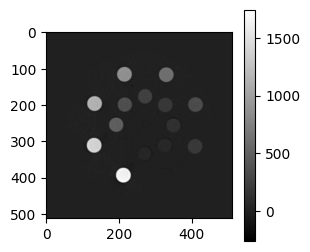

In [ ]:
# basis materials HU at 70 keV monoE
basis_materials = {
    'Ca50': 189,
    'Ca100': 329,
    'Ca200': 605,
    'Ca300': 867,
    'Ca400': 1123,
    'Ca500': 1385,
    'Ca600': 1634,
    'I2.0': 40.350,
    'I2.5': 54.613,
    'I5.0': 117.650,
    'I7.5': 180.218,
    'I10.0': 242.005,
    'I15.0': 352.105,
    'I20.0': 476.491,
    'Water': 0.077
}
basis_material_list = list(basis_materials.values())
lowE_image, highE_image = mask_image(DECT_images, [256,256], 200) # the 70 keV image masked

fig, ax = plt.subplots(1, 1, figsize=(3,3))
im = ax.imshow(lowE_image, cmap='gray')
fig.colorbar(im, ax=ax)
fig.show()

In [ ]:
# to store the resulting basis material names assigned to each pixel
dict_of_pairs = {} # dictionary of material pair assigned at each pixel
                   # {p: ("I2.0", "Water"), ...}

def find_materials_from_HU(HU_i, HU_j):
    materials_keys = list(basis_materials.keys())
    i = basis_material_list.index(HU_i)
    j = basis_material_list.index(HU_j)
    return materials_keys[i], materials_keys[j]

In [ ]:
P = 512 * 512 # total number of pixels
C = len(basis_material_list) # total number of materials
x_initial = np.zeros((P, len(basis_material_list))) # initial estimate dim = P x 15
image1D = lowE_image.reshape(P) # 1D reshaped image array
np.savetxt('image1D.csv', image1D, delimiter=',')

**Disclaimer**: In this notebook, we use only 50 pixels from row 200 of the 70 keV mono-energy image. These pixels enclose the Ca 400 mg/mL tube.

In [ ]:
Ca400_row200_start, Ca400_row200_end = 200*512+110, 200*512+160
image1D[200*512+110:200*512+160] # the Ca 400 mg/mL tube at row 200

array([ -47.,   13.,  367.,  868., 1135., 1154., 1151., 1144., 1143.,
       1147., 1141., 1119., 1107., 1122., 1124., 1119., 1131., 1127.,
       1116., 1116., 1125., 1129., 1122., 1114., 1125., 1134., 1133.,
       1124., 1114., 1106., 1105., 1100., 1091., 1102., 1118., 1117.,
       1119., 1123., 1133., 1150., 1151., 1103.,  856.,  383.,   31.,
        -39.,  -32.,  -38.,  -35.,  -30.])

**NOTE**: The negative measured HU at the pixel will result in volume fraction $(0,0,0,...,0,0)$ for the two-material assumption estimate.

In [ ]:
# this code below outputs the x_initial estimate 2D array
for p in tqdm(np.arange(Ca400_row200_start, Ca400_row200_end)):
    HU_p = image1D[p] # value of measured HU at the pixel
    if HU_p == 0: # outside the circular phantom
        continue

    count = 0 # count number of feasible solutions
    feasible_solutions = []
    for i in range(C):
        for j in range(i+1, C): # two materials selected from the basis list
            HU_i = basis_material_list[i]
            HU_j = basis_material_list[j]

            try:
                x = np.linalg.solve(np.array([[HU_i, HU_j], [1, 1]]), np.array([HU_p, 1]))
                x[np.abs(x) < 1e-6] = 0
                if np.all(x > 0):
                    feasible_solutions.append((i, j, x))
                    count += 1
            except np.linalg.LinAlgError: # won't be triggered unless HU_i = HU_j
                continue

    if count > 0: # multiple solutions
        distances = [
            (i, j, x, np.sqrt((HU_p - basis_material_list[i])**2 + (HU_p - basis_material_list[j])**2))
            for i, j, x in feasible_solutions
        ]
        best_solution = min(distances, key=lambda item: item[3])
        i, j, x, dist = best_solution
        x_initial[p][i] = x[0] # the top entry in the optimal x
        x_initial[p][j] = x[1] # the bottom entry in the optimal x

        # store info of assigned basis materials at the pixel
        HU_i, HU_j = basis_material_list[i], basis_material_list[j]
        dict_of_pairs[p] = find_materials_from_HU(HU_i,HU_j)
    else:
        # authors use "GP method" for the case of no feasible solution
        # not clear how to define f(x; HU_x) since each (x_i, x_j) is associated with (HU_i, HU_j)
        # for now, fallback to a brute-force for loop
        def objective(x, HU1, HU2, HU_pixel) :
            return np.linalg.norm(np.dot(np.array([[HU1, HU2], [1, 1]]), x) - np.array([HU_pixel, 1]))

        best_soln = None
        min_fun = float('inf')
        for i in range(C):
            for j in range(i+1, C): # two materials selected from the basis list
                HU_i = basis_material_list[i]
                HU_j = basis_material_list[j]
                xin = np.array([0.5, 0.5])
                res = minimize(objective, xin, args=(HU_i, HU_j, HU_p), bounds=[(0, 1), (0, 1)])
                if res.fun < min_fun:
                    min_fun = res.fun
                    best_soln = (i, j, res.x, HU_i, HU_j)
        i, j, x, HU_i, HU_j = best_soln
        x_initial[p][i] = x[0]
        x_initial[p][j] = x[1]
        dict_of_pairs[p] = find_materials_from_HU(HU_i, HU_j)

100%|██████████| 50/50 [00:00<00:00, 76.06it/s] 


In [ ]:
# dict_of_pairs # to confirm the pair of materials assigned at each pixel

In [ ]:
x_initial[Ca400_row200_start:Ca400_row200_end] # 50 pixels (rows)

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.32088496, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.67911504],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.8802518 , 0.1197482 , 0.        ],
       [0.        , 0.        , 0.        , 0.99609375, 0.00390625,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.95419847,
        0.04580153, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 

In [ ]:
x_initial.shape

(262144, 15)

### Note on the matrix multiplications used in the algorithm

In [ ]:
# say there are 3 materials with HU values: 1, 2, 3
A0 = sp.sparse.csr_matrix([1,2,3])

# say there are 5 pixels in total
I_P = sp.sparse.identity(5, format="csr")

# the Kronecker product of A0 and I_P is a sparse matrix
A = sp.sparse.kron(A0, I_P, format="csr")
A.toarray() # to display as numpy 2D array

array([[1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 0., 0., 3.]])

In [ ]:
# an example x_initial estimate (5 rows/pixels, 3 columns/materials)
x_initial_example = np.array([[1,0,0],[0.5,0.5,0],[0.5,0,0.5],[0,0.5,0.5],[0,1,0]])
x_initial_example

array([[1. , 0. , 0. ],
       [0.5, 0.5, 0. ],
       [0.5, 0. , 0.5],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ]])

**NOTE**: We want to act the composition matrix `A0` on each row of the sparse `x_initial` 2D array. This must be done with care. Each row of our sparse `A` matrix has as many nonzero entries as the total number of materials. For this reason, we must transpose and flatten our `x_initial` 2D array so that, when being acted on by the `A` matrix, the matrix multiplication is equivalent to acting `A0` on each pixel a total number of $P$ times (where $P$ is the total number of pixels).

In [ ]:
x0 = x_initial_example.T.flatten()
x0

array([1. , 0.5, 0.5, 0. , 0. , 0. , 0.5, 0. , 0.5, 1. , 0. , 0. , 0.5,
       0.5, 0. ])

In [ ]:
x0[:5] # map of 1st material

array([1. , 0.5, 0.5, 0. , 0. ])

In [ ]:
w1 = A.dot(x0) # 5 pixels
w1

array([1. , 1.5, 2. , 2.5, 2. ])

In [ ]:
np.tile(w1, 3)

array([1. , 1.5, 2. , 2.5, 2. , 1. , 1.5, 2. , 2.5, 2. , 1. , 1.5, 2. ,
       2.5, 2. ])

When calculating the gradient array:

* The beginning element is $x_1-x_0$

* The i-th middle element is $\frac{x_{i+1}-x_{i-1}}{2}$

* The last element is $x_{-1}-x_{-2}$

In [ ]:
np.gradient(x0)

array([-0.5 , -0.25, -0.25, -0.25,  0.  ,  0.25,  0.  ,  0.  ,  0.5 ,
       -0.25, -0.5 ,  0.25,  0.25, -0.25, -0.5 ])

### The APD Algorithm Part

In [ ]:
# use only 50 pixels from row 200 of the 70 keV mono-energy image
P = 50
x_initial = x_initial[Ca400_row200_start:Ca400_row200_end]
image1D = image1D[Ca400_row200_start:Ca400_row200_end] # ground truth

In [ ]:
len(x_initial), len(image1D)

(50, 50)

In [ ]:
A0 = sp.sparse.csr_matrix(basis_material_list) # dim = 1 x C
I_P = sp.sparse.identity(P, format="csr") # dim = P x P
A = sp.sparse.kron(A0, I_P, format="csr") # dim = P x P*C

In [ ]:
A0.toarray() # dim = 1 x 15

array([[1.89000e+02, 3.29000e+02, 6.05000e+02, 8.67000e+02, 1.12300e+03,
        1.38500e+03, 1.63400e+03, 4.03500e+01, 5.46130e+01, 1.17650e+02,
        1.80218e+02, 2.42005e+02, 3.52105e+02, 4.76491e+02, 7.70000e-02]])

In [ ]:
# Initialization
# x = [material_1=[P pixels], material_2=[P pixels], ..., material_C=[P pixels]]
x = x_initial.T.flatten() # dim = P*C x 1 column vector

w1 = A.dot(x) # dim = (P x P*C) (P*C x 1) = P x 1 column vector
w1 = np.tile(w1, C) # dim = P*C x 1 to ensure w1, w2, w3 have the same shape as x
# w1 = [[p1, ..., p50], [p1, ..., p50], ..., [p1, ..., p50]]
w2 = np.gradient(x)
w3 = x

In [ ]:
w1.shape == w2.shape == w3.shape == (50*15,)

True

In [ ]:
# Initialization of APD parameters
theta = 1.0 # as printed in pseudo-code
v = 0.5 # choice in [0,1] decreases step size in line search scheme
t = 1.0 # choice > 0 # step size in line search scheme
beta = 1.0 # choice > 0
gamma = 1.0 # choice > 0

max_iterations = 100 # max number of iterations for outer loop
tolerance = 1e-5  # tolerance for convergence in outer loop

# L0 norm regularization parameter
sigma = 0.025 # best result according to paper

# TV regularization parameter
delta = 1.5e-6 # best result according to paper

In [ ]:
# Main iteration
for k in tqdm(np.arange(0, max_iterations+1)):
    x_old, w1_old, w2_old, w3_old = x, w1, w2, w3
    beta_old, theta_old = beta, theta
    t_old = t

    x = x_old - t_old * (w1_old + w2_old + w3_old)
    # Check for convergence
    if np.linalg.norm(x - x_old) < tolerance:
        break

    x[np.abs(x) < np.sqrt(2 * sigma * t)] = 0 # hard thresholding
    beta = beta_old * (1 + gamma * t_old)

    lowBound = t_old * np.sqrt(beta_old / beta)
    highBound = t_old * np.sqrt((beta_old / beta) * (1 + theta_old))
    t = np.random.uniform(lowBound, highBound) # choose any t within the bounds

    # Line search of optimal (large enough) updating step for outer iteration convergence
    while True:
        theta = t / t_old
        x_hat = x + theta * (x - x_old)
        s = beta * t

        # Compute t_hat
        w3_old_over_s_sorted = np.sort(w3_old/s)
        n = len(w3_old_over_s_sorted)
        for p in range(n):
            accumulated_value = (np.sum(w3_old_over_s_sorted[p+1:]) - 1) / (n - p)
            if w3_old_over_s_sorted[p] >= accumulated_value:
                break
        t_hat = (np.sum(w3_old_over_s_sorted[p+1:]) - 1) / (n - p)


        w1_hat = w1_old + s * np.tile(A.dot(x_hat), C)
        w2_hat = w2_old + s * np.gradient(x_hat)
        w3_hat = w3_old + s * x_hat

        w1 = (w1_hat - s * np.tile(image1D, C)) / (1 + s)
        w2 = np.where(np.abs(w2_hat) <= delta, w2_hat, np.where(w2_hat < -delta, -delta, delta))
        w3 = np.where(w3_hat >= s * t_hat, s * t_hat, w3_hat)

        obj = np.sqrt(np.linalg.norm(A.dot(w1-w1_old))**2 + np.linalg.norm(np.gradient(w2-w2_old))**2 + np.linalg.norm(w3-w3_old)**2)
        dw_norm = np.sqrt(np.linalg.norm(w1-w1_old)**2 + np.linalg.norm(w2-w2_old)**2 + np.linalg.norm(w3-w3_old)**2)

        if np.sqrt(beta) * t * obj <= dw_norm:
            break
        t *= v
print(k)

100%|██████████| 101/101 [00:01<00:00, 66.09it/s]

100


In [ ]:
x.reshape(C,P)

array([[ 0.00000000e+00,  1.20061374e+01,  3.37742485e+02,
         7.98644013e+02,  1.04421913e+03,  1.06166474e+03,
         1.05890150e+03,  1.05246185e+03,  1.05154326e+03,
         1.05522257e+03,  1.04969937e+03,  1.02945894e+03,
         1.01842380e+03,  1.03222534e+03,  1.03406278e+03,
         1.02946412e+03,  1.04050407e+03,  1.03682122e+03,
         1.02670189e+03,  1.02670442e+03,  1.03498479e+03,
         1.03866271e+03,  1.03222130e+03,  1.02486369e+03,
         1.03498568e+03,  1.04326402e+03,  1.04234177e+03,
         1.03406076e+03,  1.02486104e+03,  1.01750230e+03,
         1.01658269e+03,  1.01198175e+03,  1.00370391e+03,
         1.01382690e+03,  1.02854515e+03,  1.02762339e+03,
         1.02946400e+03,  1.03314495e+03,  1.04234644e+03,
         1.05798505e+03,  1.05889682e+03,  1.01470621e+03,
         7.87416226e+02,  3.52250048e+02,  2.84710805e+01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00